#### Student Name: Alan Gewerc
#### Student ID: 29961246
#### Student email: agew0001@student.monash.edu



<br><br>
# Part A. Document Clustering

In this part, you solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization) for document clustering.

## Question 1 [EM for Document Clustering, 40 Marks]


    II. Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

#### Import Libraries

In [1]:
library('NLP') # text processing
library('tm') # load Text Mining library

#### Helper Function 

This function is needed to prevent numerical overflow/underflow when working with small numbers, because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities). <br>

**Example**: Suppose we are interested in p1 * p2 * p3 + q1 * q2 * q3 where all numbers are probabilities in [0,1] 
To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
Hence our approach is to form the vector `v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)]`
Then get the results by: `exp(logSum(v))`.

- Input:    logA1, logA2 ... logAn
- Output:   log(A1+A2+...+An)


In [2]:
logSum <- function(v) {
  m = max(v)
  return (m + log(sum(exp(v-m))))
}

## --- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=100){
  set.seed(seed)
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}


## E-Step and M-Step for Document Clustering 


The Expectation-Maximization algorithm has two steps, the `Expectation` and the `Maximization`. In addition, it can be implemented in two different approaches, the `soft` and the `hard`. In the following step we will implement four different functions. They are the following: 

- **E-step soft**: We use the current parameter values $\theta^{old}$ to find the posterior distribution of the latent variables given by $p(Z|X, \theta^{old})$. We then use this posterior distribution to find the expectation of the complete-data log likelihood evaluated for some general parameter value. <br>

Evaluate  $p(Z|X, \theta^{old})$ <br><br>

- **E-step hard**: We use the current parameter values $\theta^{old}$ to find the posterior distribution of the latent variables given by $p(Z|X, \theta^{old})$. We then use this posterior distribution to find the expectation of the complete-data log likelihood evaluated for some general parameter value. <br>

$Z^* \leftarrow p(Z|X, \theta^{old})$ <br><br>

- **M-step soft**: We determine the revised parameter estimate $\theta^{new}$ by maximising this function: <br>

$\theta^{new} := argmax_{\theta} Q(\theta, \theta^{old})$ <br>

$argmax_{\theta} \sum{z} p(z | X, \theta^{old}) lnp(X, Z | \theta) $ <br><br>
    
- **M-step soft**: We determine the revised parameter estimate $\theta^{new}$ by maximising this function: <br>

$\theta^{new} := argmax_{\theta} Q(\theta, \theta^{old})$ <br>

$argmax_{\theta} lnp(X, Z^* | \theta) $ <br><br>



Each of this functions will receive three inputs:
1. `gamma`: Matrix of posterior probabilities (N x K)
2. `model`: List of parameters from $\theta$
    - rho (prior probability) 
    - mu (average of each)
3. `counts`: The word-document frequency matrix <br><br>

In the E-Step, the return will be `gamma` updated.
In the M-Step, the return will be `model` with updated parameters.


### E-Step Soft and Hard
The sole difference in both functions is in the last line, where we return in the hard function the choice of the highest probability. 


In [3]:
# this function implements the E-step of the soft-EM
E.step.soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] # number of clusters
  
  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}



# this function implements the E-step of the hard-EM
E.step.hard <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] # number of clusters
  
  # E step:    
  for (n in 1:N){
    for (k in 1:K){
        
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  z <- max.col(gamma) # selecting the cluster with the highest probability
    
  return (z)
}

### M-Step Soft and Hard

In [4]:
M.step.soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
    
  # add small value to matrix to avoid errors (denominator 0)
  eps = matrix(1e-10, nrow = W, ncol = N)
  counts = counts + eps
  
  for (k in 1:K){
      
    # recalculate the parameteres
    model$rho[k] <- sum(gamma[,k])/N
    model$mu[k,] <- t((counts)%*%gamma[,k])/sum(t((counts)%*%gamma[,k]))

  }
    
  # Return the result
  return (model)
}


M.step.hard <- function(z, model, counts){
    
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  
    # add small value to matrix to avoid errors (denominator 0)
    eps = matrix(1e-10, nrow = W, ncol = N)
    counts = counts + eps
    
    for (k in 1:K){
        
        # recalculate the estimations
        model$rho[k] = sum(z == k)/N # the relative cluster size
        model$mu[k,] <- rowSums(counts[ , z==k]) / sum(rowSums(counts[ , z==k])) # new means
    
  }
  # Return the result
  return (model)
}

### The training objective function

In [5]:
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 

train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
  
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}


## EM-Algorithm for Document Clustering

We implement further two functions, the first is the EM-Soft and the Second is the EM-Hard.


### EM Soft for Document Clustering

In [6]:
##--- EM for Document Clustering --------------------------------------------
EM.soft <- function(counts, K=4, max.epoch=10, seed=1234){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)
  
  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step.soft(gamma, model, counts)
    # M Step
    model <- M.step.soft(gamma, model, counts)
    
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"= model, "gamma"=gamma))
}

### EM Hard for Document Clustering

In [7]:
EM.hard <- function(counts, K=4, max.epoch=10, seed=1234){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)
  
  print(train_obj(model, counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    z <- E.step.hard(gamma, model, counts)
    # M Step
    model <- M.step.hard(z, model, counts)
    
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"= model, "z" = z))
}


    III. Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [8]:
read.data <- function(file.name='./data/EM.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
    
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  
  # store the unlabeled texts    
  uid <- paste0("doc_", formatC(1:length(labels), width = 4, format = "d", flag = "0"))
  docs <- data.frame(doc_id = uid, text = unlist(lapply(docs, function(x) x[2])))
  
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

In [9]:
data <- read.data(file.name='./data/EM.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
counts <- data$word.doc.mat        

In [10]:
res.soft <-EM.soft(counts, K = 4, max.epoch = 10)
label.soft <- max.col(res.soft$gamma)

[1] 2173220
[1] 1946264
[1] 1926618
[1] 1916861
[1] 1911561
[1] 1907374
[1] 1906228
[1] 1905621
[1] 1905456
[1] 1905341
[1] 1905144


In [11]:
res.hard <-EM.hard(counts, K = 4, max.epoch = 10)
label.hard <- res.hard$z

[1] 2173220
[1] 1946556
[1] 1928455
[1] 1919070
[1] 1914559
[1] 1909589
[1] 1907810
[1] 1906553
[1] 1906187
[1] 1906048
[1] 1905912


### Cluster Visualization

    IV. Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM in the same way we did in Activity 4.2. Then, visualize the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2). Attach the plots to your PDF report and report how and why the hard and soft-EM are different, based on your plots in the report.

In [12]:
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

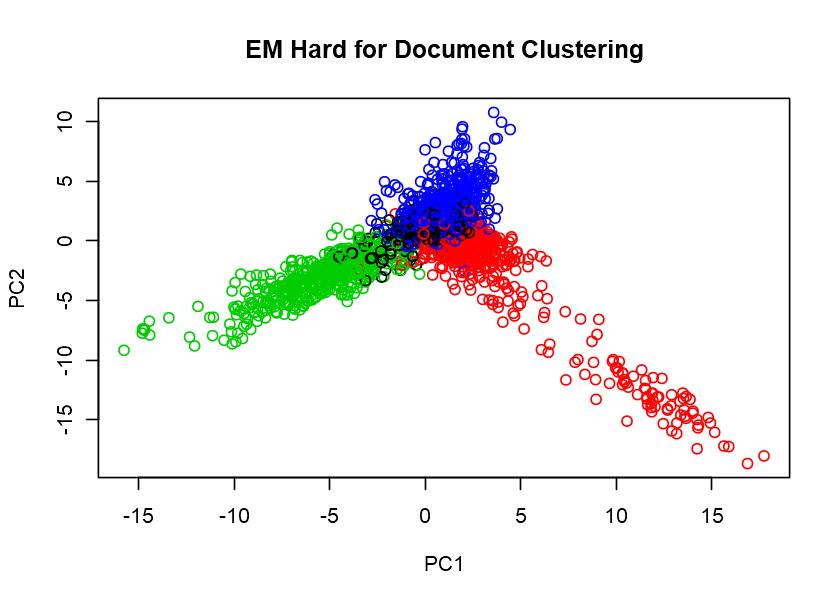

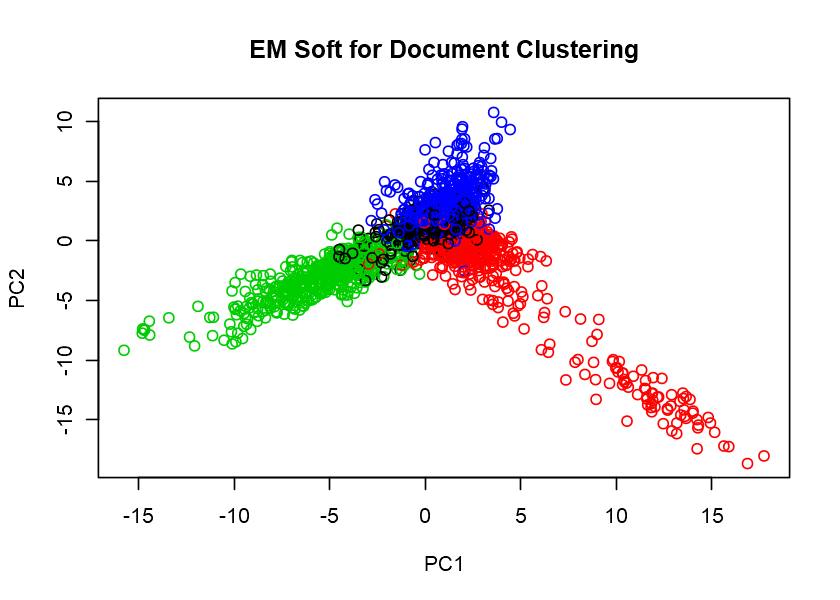

In [13]:
options(repr.plot.width=7, repr.plot.height=5) # area of display


counts <- scale(counts)

cluster.viz(t(counts), label.hard, "EM Hard for Document Clustering")
cluster.viz(t(counts), label.soft, "EM Soft for Document Clustering")